# MobileNet V2


#### Google Colab Doğrulama

3 tane datasetimiz var. Onlara ulaşabilmek adına doğrulama işlemlerini gerçekleştiriyoruz.


In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Bağlanıp bağlanmadığımız görmek amacıyla drive daki çalışma alanımızın içindekileri listele komutunu çalıştırıyoruz.

In [ ]:
ls "/content/drive/My Drive/CT"

checkpoint    denseNet_model_78.h5               my_model_fra.h5  transfer/
covid/        earlystop_model.h5                 non-covid/       works/
COVID/        model.h5                           NonCOVID/
CT_COVID/     model_weights.data-00000-of-00001  Normalize/
CT_NonCOVID/  model_weights.index                saved_models/


#### Kütüphaneler

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121, MobileNetV2


from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping

Normalize edilmiş değerleri önceki ipynb dosyamızda npy olarak kaydetmiştik. Bu aşama, işlemlerimizi hızlandırmak için yapıldı. numpy kütüphanesinden load() metodunu çağırarak normalize olmuş datamızı kullanmaya başlayabiliriz.

In [ ]:
a= "/content/drive/My Drive/CT/Normalize/"

#300 veri bulunan dataset
l1x=a+ "X_nparray300.npy"
l1y=a+ "y_nparray300.npy"

#1200 veri bulunan dataset
l2x=a+ "X_nparray1200.npy"
l2y=a+ "y_nparray1200.npy"

#3000 veri bulunan dataset
l3x=a+ "X_nparray3000.npy"
l3y=a+ "y_nparray3000.npy"

loaded_array_x1200 = np.load(l2x)
loaded_array_y1200 = np.load(l2y)

In [ ]:
X=loaded_array_x1200
y=loaded_array_y1200

Datamızın doğru yüklendiğine emin olmak için shape metodunu kullanarak inceliyoruz.

In [ ]:
print("Shape of input data: {} and shape of target variable: {}".format(X.shape, y.shape))

Shape of input data: (2481, 64, 64, 3) and shape of target variable: (2481, 2)


In [ ]:
SEED= 42

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

Verisetimiz üzerinde kaç tane forward ve backward propagation yapılacağını ayarladığımız apoch sayımızı 50,100 ve 200 vereceğiz.

Tüm veri kümesini aynı anda sinir ağına veremeyeceğimiz için dataseti parçalara böleriz. Yani batch size olarak adlandırdığımız bu hiperparametre üzerinde çalışılacak bir parti örneğin miktarını bize söyler. Burada 64'er adet image lar halinde modelimize göndereceğiz.

In [ ]:
EPOCHS = 150
# 50, 100, 200
SIZE=64
N_ch=3
BATCH_SIZE = 64
SEED= 42

IMG_W= 64
IMG_H= 64
CHANNELS = 3

INPUT_SHAPE=(IMG_W, IMG_H, CHANNELS)

In [ ]:
from keras.applications.densenet import DenseNet169, preprocess_input
import keras
import tensorflow as tf

def build_MobileNetV2():
    mobileNet = MobileNetV2(alpha=0.35,include_top=False,weights='imagenet')

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = mobileNet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'sigmoid', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model=build_MobileNetV2()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
mobilenetv2_0.35_224 (Functi (None, None, None, 1280)  410208    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3279

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error



annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)



datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
27/27 - 6s - loss: 1.0779 - accuracy: 0.4890 - val_loss: 0.7467 - val_accuracy: 0.5383

Epoch 00001: val_loss improved from inf to 0.74673, saving model to model_CNN2.h5
Epoch 2/150
27/27 - 2s - loss: 1.0208 - accuracy: 0.5239 - val_loss: 0.7199 - val_accuracy: 0.5893

Epoch 00002: val_loss improved from 0.74673 to 0.71985, saving model to model_CNN2.h5
Epoch 3/150
27/27 - 2s - loss: 0.9845 - accuracy: 0.5395 - val_loss: 0.7095 - val_accuracy: 0.5946

Epoch 00003: val_loss improved from 0.71985 to 0.70948, saving model to model_CNN2.h5
Epoch 4/150
27/27 - 2s - loss: 0.9404 - accuracy: 0.5670 - val_loss: 0.6853 - val_accuracy: 0.6295

Epoch 00004: val_loss improved from 0.70948 to 0.68528, saving model to model_CNN2.h5
Epoch 5/150
27/27 - 2s - loss: 0.9034 - accuracy: 0.5921 - val_loss: 0.6808 - val_accuracy: 0.6443

Epoch 00005: val_loss improved from 0.68528 to 0.68077, saving model to model_CNN2.h5
Epoch 6/150
27/27 - 2s - loss: 0.8982 - accuracy: 0.5975 - val_loss: 0.671

In [ ]:
print("SGD")
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

SGD
training_accuracy   =  0.7697368264198303
validation_accuracy =  0.8040268421173096
training_loss   =  0.5513930320739746
validation_loss =  0.40666982531547546


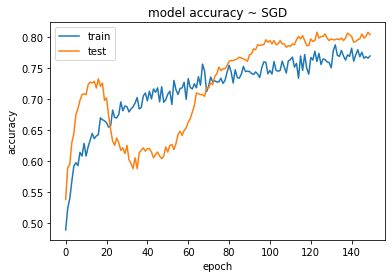

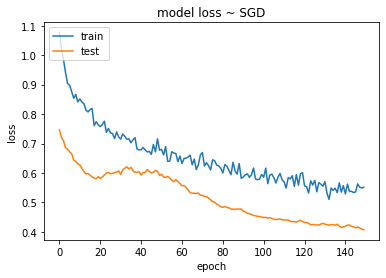

In [ ]:
# Accuracy ve Loss değerlerinin görselleştirilmeleri

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy ~ Adagrad')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss ~ Adagrad')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)


Accuracy: 0.804027
Precision: 0.824207
Recall: 0.770889
F1 score: 0.796657
Cohens kappa: 0.607946
ROC AUC: 0.803894
Precision =  0.824
[[313  61]
 [ 85 286]]


In [ ]:
# R2 & MSE

def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: 0.4538 MSE: 0.1365
Test R2 Score:    0.4721 MSE: 0.1320


### Karmaşıklık Matrisi

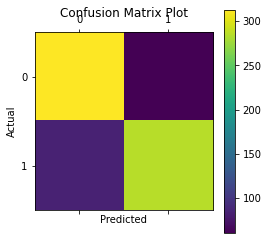

In [ ]:
plt.matshow(cf)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

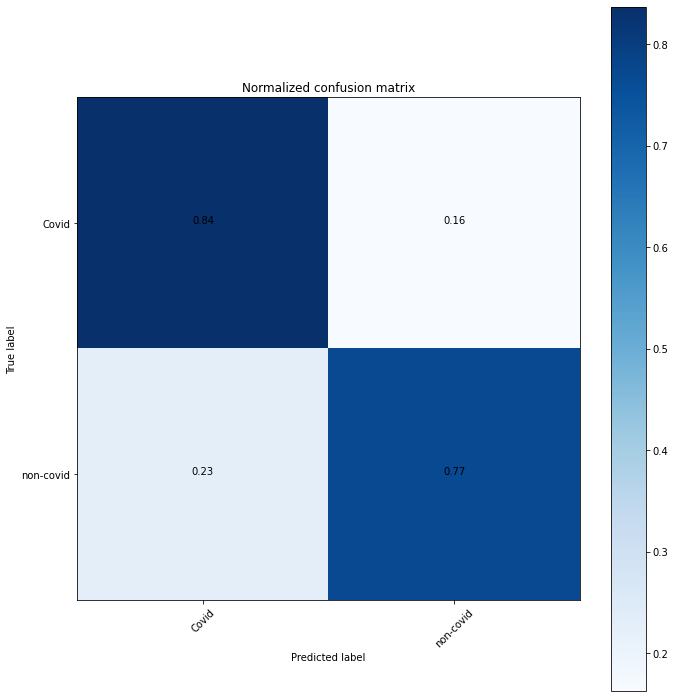

In [ ]:


class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

#### ROC AUC Score

roc_auc_score for Model:  0.8038939417962725


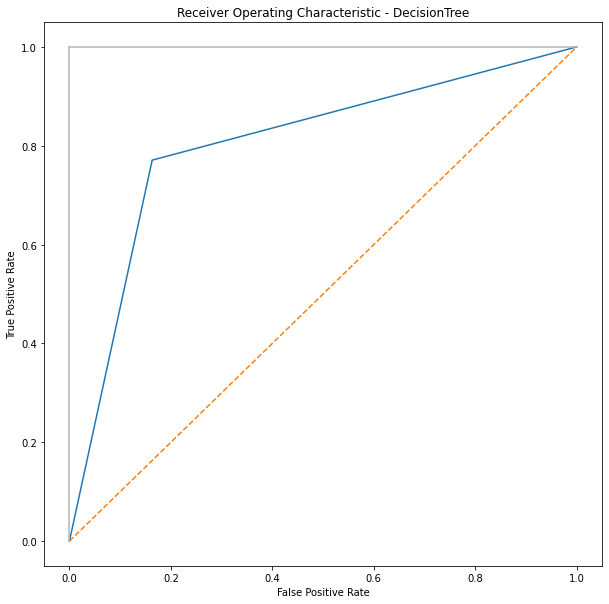

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

# SGD
SGD optimizer ını kullanarak aşağıdaki sonuçlar elde edildi(100 epoch)

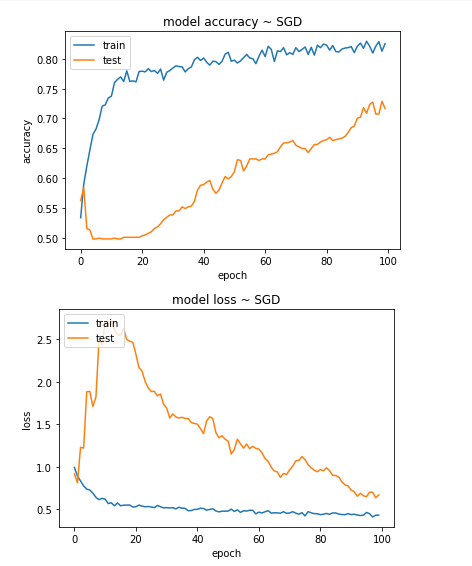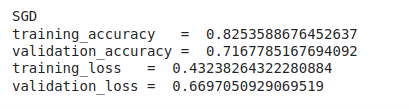